In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import HTML

class visualization:
    def __init__(self, S, F):
        '''
          Η μέθοδος αυτή αρχικοποιεί ένα αντικείμενο τύπου visualization.
          Είσοδος: 
          -> S: το σημείο εκκίνσης της αναζήτησης
          -> F: το σημείο τερματισμού
        '''
        self.S = S
        self.F = F
        self.images = []
    
    def draw_step(self, grid, frontier, expanded_nodes):
        '''
          Η συνάρτηση αυτή καλείται για να σχεδιαστεί ένα frame στο animation (πρακτικά έπειτα από την επέκταση κάθε κόμβου)
          Είσοδος: 
          -> grid: Ένα χάρτης τύπου grid
          -> frontier: Μια λίστα με τους κόμβους που ανήκουν στο μέτωπο της αναζήτησης
          -> expanded_nodes: Μια λίστα με τους κόμβους που έχουν ήδη επεκταθεί
          Επιστρέφει: None
          Η συνάρτηση αυτή πρέπει να καλεστεί τουλάχιστον μια φορά για να μπορέσει να σχεδιαστει ένα animation (πρεπεί το animation να έχει τουλάχιστον ένα frame).
        '''
        image = np.zeros((grid.N, grid.N, 3), dtype=int)
        image[grid.grid == 0] = [255, 255, 255]
        image[grid.grid == 1] = [0, 0, 0]
        
        for node in expanded_nodes:
            image[node] = [0, 0, 128]

        for node in frontier:
            image[node] = [0, 225, 0]

        image[self.S] = [50, 168, 64]
        image[self.F] = [168, 50, 50]
        self.images.append(image)
    
    def add_path(self, path):
        '''
          Η συνάρτηση αυτή προσθέτει στο τελευταίο frame το βέλτιστο μονοπάτι.
          Είσοδος:
          -> path: Μια λίστα η όποια περιέχει το βέλτιστο μονοπάτι (η οποία πρέπει να περιέχει και τον κόμβο αρχή και τον κόμβο στόχο)
          Έξοδος: None
        '''
        for n in path[1:-1]:
            image = np.copy(self.images[-1])
            image[n] = [66, 221, 245]
            self.images.append(image)
        for _ in range (100):
            self.images.append(image)
        
    def create_gif(self, fps = 30, repeat_delay = 2000):
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        fig = plt.figure()
        plt.axis('off')
        ims = []
        for img in self.images:
            img = plt.imshow(img)
            ims.append([img])
        ani = animation.ArtistAnimation(fig, ims, interval=1000//fps, blit=True, repeat_delay= repeat_delay)
        plt.close(fig)
        return ani
        
    def save_gif(self, filename, fps = 30):
        '''
            Η συνάρτηση αυτή ξαναδημιουργεί και αποθηκεύει το animation σε ένα αρχείο.
            Είσοδος:
            -> Το όνομα του αρχείου με κατάληξη .gif
            Έξοδος: (None)
        '''
        ani = self.create_gif(fps)
        writer = PillowWriter(fps= fps)
        ani.save(filename, writer=writer)

    def show_gif(self, fps= 30, repeat_delay = 2000):
        '''
            Η συνάρτηση αυτή εμφανίζει inline το animation.
            Είσοδος:
            -> fps: τα frames per second
            Έξοδος: Το αντικείμενο που παίζει το animation
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        ani = self.create_gif(fps, repeat_delay)
        # return HTML(ani.to_html5_video())
        return HTML(ani.to_jshtml())

    def show_last_frame(self):
        '''
            Η μέθοδος αυτή εμφανίζει inline το τελευταίο frame που έχει δημιουργήθει.
            Είσοδος:
            Έξοδος: Το αντικείμενο που εμφανίζει την εικόνα.
            Exceptions: EmptyStackOfImages αν το animation δεν έχει ούτε ένα frame, δηλαδή αν η draw_step δεν έχει καλεστεί ποτέ.
        '''
        if len(self.images) == 0:
            raise EmptyStackOfImages("Error! You have to call 'draw_step' at  first.")
        else:
            plt.imshow(self.images[-1])


class EmptyStackOfImages(Exception):
    pass

In [15]:
%matplotlib inline
import numpy as np
from queue import LifoQueue
from random import shuffle, uniform
import matplotlib.pyplot as plt
import random

class grid():
            
    def __init__(self, N, S, F):
        
        ## Make sure start and end are within the grid
        assert N > 2
        assert S[0] < N
        assert S[1] < N
        assert F[0] < N
        assert F[1] < N

        assert S[0] > 0
        assert S[1] > 0
        assert F[0] > 0
        assert F[1] > 0

        self.N = N

        ## Initialize grid with obstacles
        self.grid = np.ones((N, N), dtype=np.int32)
        self.walls = []
        ## Start and end position have no obstacles
        self.grid[S]=0
        self.grid[F]=0
        obstacle_free_points = {S, F}
        
        #function that counts the neighbors of a cell
        def count_neigh (g,F,N):
            #print("F[0] is : ", F[0], "\n", "F[1] is: ", F[1])
            c = 0
            if F[1]>-1:
                if g[F[0]][F[1]-1] == 0:
                    c=c+1
            if F[1]<N-1:
                if g[F[0]][F[1]+1] == 0:
                    c=c+1
            if F[0]>1:
                if g[F[0]-1][F[1]] == 0:
                    c=c+1
            if F[0]<N-1:        
                if g[F[0]+1][F[1]] == 0:
                    c=c+1
            return c
        
        #our starting point will be S
        #add it's surrounding walls to the wall list
        self.walls.append([S[0]-1, S[1]])
        self.walls.append([S[0], S[1]-1])
        self.walls.append([S[0], S[1]+1])
        self.walls.append([S[0]+1, S[1]])
        
        #we will mark the walls with 2 and the unvisited cells with 1
        #add the walls to the grid

        self.grid[S[0]-1][S[1]] = 2
        self.grid[S[0]][S[1]-1] = 2
        self.grid[S[0]][S[1]+1] = 2
        self.grid[S[0]+1][S[1]] = 2
        
        while(self.walls):
              
            #choose a random wall to start
        
            curr_wall = self.walls[random.randint(0,len(self.walls)-1)]
            #count the neighbors of the cell
            cn = count_neigh(self.grid, curr_wall, N)
            
            if curr_wall[0]!=0 and curr_wall[0]!=(N-1) and curr_wall[1]!=0 and curr_wall[1]!=(N-1) and cn==1:
                if curr_wall[0]-1>0 and curr_wall[0]+1<N-1:
                    if self.grid[curr_wall[0]-1][curr_wall[1]] == 1 and self.grid[curr_wall[0]+1][curr_wall[1]] == 0: 
                        #print("The right wall is 1: ", curr_wall)
                        self.grid[curr_wall[0]-1][curr_wall[1]]=0
                        self.grid[curr_wall[0]][curr_wall[1]]=0
                        if curr_wall[0]-2>-1 and self.grid[curr_wall[0]-2][curr_wall[1]] != 0:
                            self.walls.append([curr_wall[0]-2, curr_wall[1]])
                            self.grid[curr_wall[0]-2][curr_wall[1]] = 2
                        if self.grid[curr_wall[0]-1, curr_wall[1]-1] != 0:
                            self.walls.append([curr_wall[0]-1, curr_wall[1]-1])
                            self.grid[curr_wall[0]-1][curr_wall[1]-1] = 2
                        if self.grid[curr_wall[0]-1, curr_wall[1]+1] !=0:
                            self.walls.append([curr_wall[0]-1, curr_wall[1]+1])
                            self.grid[curr_wall[0]-1][curr_wall[1]+1] = 2
                            
                        #print(self.grid)
                        #delete the wall and choose another curr_wall
                        for wall in self.walls:
                            if wall[0] == curr_wall[0] and wall[1] == curr_wall[1]:
                                self.walls.remove([wall[0],wall[1]])
                                break
                        continue #go to the while loop again and choose a random wall from the wall list
                        
                    if self.grid[curr_wall[0]-1][curr_wall[1]] == 0 and self.grid[curr_wall[0]+1][curr_wall[1]] == 1:
                        #print("the right wall is 2: ", curr_wall)
                        self.grid[curr_wall[0]+1][curr_wall[1]]=0
                        self.grid[curr_wall[0]][curr_wall[1]]=0
                        if curr_wall[0]+2 < N and self.grid[curr_wall[0]+2][curr_wall[1]] != 0:
                            self.walls.append([curr_wall[0]+2, curr_wall[1]])
                            self.grid[curr_wall[0]+2][curr_wall[1]] = 2
                        if self.grid[curr_wall[0]+1, curr_wall[1]-1] != 0:
                            self.walls.append([curr_wall[0]+1, curr_wall[1]-1])
                            self.grid[curr_wall[0]+1][curr_wall[1]-1] = 2
                        if self.grid[curr_wall[0]+1, curr_wall[1]+1] !=0:
                            self.walls.append([curr_wall[0]+1, curr_wall[1]+1])
                            self.grid[curr_wall[0]+1][curr_wall[1]+1] = 2
                        #print(self.grid)
                        for wall in self.walls:
                            if wall[0] == curr_wall[0] and wall[1] == curr_wall[1]:
                                self.walls.remove([wall[0],wall[1]])
                                break
                        continue
                        
                if curr_wall[1]+1 < N-1 and curr_wall[1]-1 > 0:
                    if self.grid[curr_wall[0]][curr_wall[1]+1] == 1 and self.grid[curr_wall[0]][curr_wall[1]-1] == 0:
                        #print("the right wall is 3: ", curr_wall)
                        self.grid[curr_wall[0]][curr_wall[1]+1]=0
                        self.grid[curr_wall[0]][curr_wall[1]]=0
                        if curr_wall[1]+2 < N  and self.grid[curr_wall[0]][curr_wall[1]+2] != 0:
                            self.walls.append([curr_wall[0], curr_wall[1]+2])
                            self.grid[curr_wall[0]][curr_wall[1]+2] = 2
                        if self.grid[curr_wall[0]-1, curr_wall[1]+1] != 0:
                            self.walls.append([curr_wall[0]-1, curr_wall[1]+1])
                            self.grid[curr_wall[0]-1][curr_wall[1]+1] = 2
                        if self.grid[curr_wall[0]+1, curr_wall[1]+1] !=0:
                            self.walls.append([curr_wall[0]+1, curr_wall[1]+1])
                            self.grid[curr_wall[0]+1][curr_wall[1]+1] = 2
                        #print(self.grid)
                        for wall in self.walls:
                            if wall[0] == curr_wall[0] and wall[1] == curr_wall[1]:
                                self.walls.remove([wall[0],wall[1]])
                                break
                        continue

                    if self.grid[curr_wall[0]][curr_wall[1]+1] == 0 and self.grid[curr_wall[0]][curr_wall[1]-1] == 1:
                        #print("the right wall is 4: ", curr_wall)
                        self.grid[curr_wall[0]][curr_wall[1]-1]=0
                        self.grid[curr_wall[0]][curr_wall[1]]=0
                        if curr_wall[1]-2 > -1  and self.grid[curr_wall[0]][curr_wall[1]-2] != 0:
                            self.walls.append([curr_wall[0], curr_wall[1]-2])
                            self.grid[curr_wall[0]][curr_wall[1]-2] = 2
                        if self.grid[curr_wall[0]-1, curr_wall[1]-1] != 0:
                            self.walls.append([curr_wall[0]-1, curr_wall[1]-1])
                            self.grid[curr_wall[0]-1][curr_wall[1]-1] = 2
                        if self.grid[curr_wall[0]+1, curr_wall[1]-1] !=0:
                            self.walls.append([curr_wall[0]+1, curr_wall[1]-1])
                            self.grid[curr_wall[0]+1][curr_wall[1]-1] = 2
                        #print(self.grid)
                        for wall in self.walls:
                            if wall[0] == curr_wall[0] and wall[1] == curr_wall[1]:
                                self.walls.remove([wall[0],wall[1]])
                                break
                        continue 




            
            #If the wall doesnt belong to any category we have to delete it
            for wall in self.walls:
                if wall[0] == curr_wall[0] and wall[1] == curr_wall[1]:
                    self.walls.remove([wall[0],wall[1]])
            continue
                        
        
        
        C = 0
        F_walls = []
        n = 0
        
        if self.grid[F[0]][F[1]-1] == 2:
            F_walls.append([F[0], F[1]-1])
        
        
        if self.grid[F[0]][F[1]+1] == 2:
            F_walls.append([F[0], F[1]+1])
        
        
        if self.grid[F[0]-1][F[1]] == 2:
            F_walls.append([F[0]-1, F[1]])
            
        
        if self.grid[F[0]+1][F[1]] == 2:
            F_walls.append([F[0]+1, F[1]])
        
        n = count_neigh(self.grid, F, N)            
        if n == 0:
            C = random.choice(F_walls)
            self.grid[C[0]][C[1]] = 0
        
        #print(self.grid)
        i=j=0
        #turn the unvisited cells into walls in order to draw the grid properly 
        for i in range(N):
            for j in range(N):
                if self.grid[i][j] == 2:
                    self.grid[i][j] = 1
    
    def draw_map(self, S=None, F=None, path=None):
        image = np.zeros((self.N, self.N, 3), dtype=int)
        image[self.grid == 0] = [255, 255, 255]
        image[self.grid == 1] = [0, 0, 0]
        if S:
            image[S] = [50, 168, 64]
        if F:
            image[F] = [168, 50, 50]
        if path:
            for n in path[0:-1]:
                image[n] = [66, 221, 245]

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()

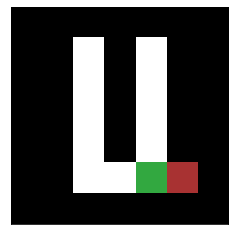

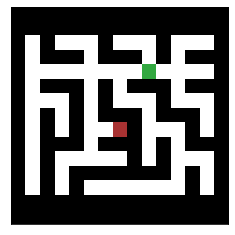

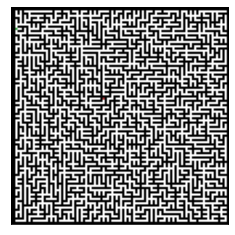

In [3]:
for N, S, F in (7, (5, 4), (5,5 )), (15, (4,9), (8, 7)), (100, (10, 2), (42, 42)):
    map = grid(N, S, F)
    map.draw_map(S, F)

In [6]:

import heapq

class pathfinder():

    def __init__(self, S, F, grid, c, h):
        self.S = S
        self.F = F
        self.grid = grid
        self.cost = c
        self.heuristic = h

        self.vis = visualization(S, F)
        self.path=[]
        self.expanded_nodes = 0 #addition
        self.opened = [] 

        self.closed = []       #processed cells
        self.parent = []
        self.costs = [] #addition
        self.heur = []
        self.g = []
        self.f = []
        
        maze = tuple(map.grid)

        def list_adjacents (i, j): #returns the list of the adjacents of a cell
            adjacents = []
            if i>0 and map.grid[i-1][j]!=1:
                adjacents.append((i-1,j))
            if i<N-1 and map.grid[i+1][j]!=1:
                adjacents.append((i+1,j))
            if j>0 and map.grid[i][j-1]!=1:
                adjacents.append((i,j-1))
            if j<N-1 and map.grid[i][j+1]!=1:
                adjacents.append((i,j+1))
            return adjacents
        
        #self.f = np.zeros((N, N))
        self.g= np.zeros((N, N))
        self.heur= np.zeros((N, N))
        start_h = h(S[0],S[1])
        
        
        rowsp=[]
        for i in range(N):
            for j in range(N):
                rowsp.append((-1,-1))
                self.f.append(1000000)
            self.parent.append(rowsp)
            rowsp=[]
    
        #print(len(self.f))

        #the a* algorithm starts here
        self.parent[S[0]][S[1]] = (0,0) #set this parent in order to find the start of the path
        self.opened.append(S) #we begin by adding the start to the open list
        self.heur[S[0]][S[1]] = h(S[0], S[1]) #we initialize the heuristic value of the start
        self.f[S[0]*N +S[1]] = h(S[0], S[1])  #we initialize the f value of the start
        self.g[S[0]][S[1]] = 0
        
        while len(self.opened):
            minval = self.f.index(min(self.f)) 
            
   
            cell = (int(minval/N), minval%N)
            #print("everytime cell is:  ", cell)
            #print("its value is: ", self.f[minval])
            #print("everytime opened list is 1: ", self.opened)
            #print("closed list is: ", self.closed)
            

            self.closed.append(cell)
            self.opened.remove(cell)
            
            #print("after the remove opened list is: ", self.opened)
            

            if cell == F:
                break
               
            adj_cells = list_adjacents(cell[0], cell[1])
            
            for adj_cell in adj_cells:
                #print("the neighbor is: ", adj_cell)

                x = adj_cell[0]
                y = adj_cell[1]

                if maze[x][y] == 1  or adj_cell  in self.closed: continue
                if self.g[x][y] > self.g[cell[0]][cell[1]] + c() or adj_cell not in self.opened: 
                    self.g[x][y] = self.g[cell[0]][cell[1]] + c()
                            
                    self.heur[x][y] = h(x,y)
                        
                    self.parent[x][y] = (cell[0], cell[1])
                        
                    self.f[x*N +y] = self.g[x][y] + self.heur[x][y]
                    if adj_cell not in self.opened:
                        self.opened.append(adj_cell)
                        #print("after the adding of adj opened list is: ", self.opened)
            self.f[minval] = 1000000
        self.path = []
        s = self.parent[F[0]][F[1]]
        print(len(self.closed))
        while s!=(0,0):
            self.path.append(s)
            s=self.parent[s[0]][s[1]]
        pass
       
    def get_path(self):
        return self.path
        

163


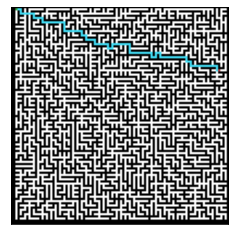

228


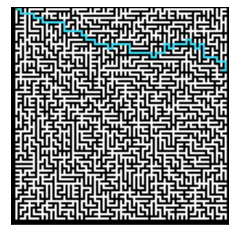

3231


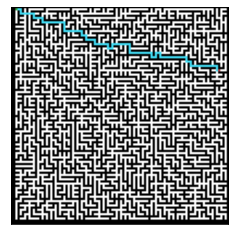

826


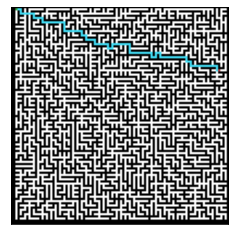

1150


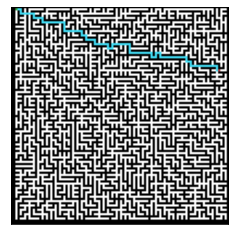

In [7]:
import math
N = 100
S = (1, 2)
F = (29, 95)

def manhattan_heuristic (i, j):
    return abs(i-F[0]) + abs(j-F[1])

def euclidean_heuristic(i, j):
    dx = abs(i-F[0])
    dy = abs(j-F[1])
    return  math.sqrt(dx * dx + dy * dy)
def zero_heur(i,j):
    return 0



def c1():
    return 1
def c2():
    return 0
   
    
#𝑔(𝑛)=0 & ℎ(𝑛)={manhattan(𝑛),euclidean(𝑛)}    
map = grid(N, S, F)
pf = pathfinder(S, F, map, c2,  manhattan_heuristic )
map.draw_map(S, F, pf.get_path())

#map = grid(N, S, F)
pf = pathfinder(S, F, map, c2,  euclidean_heuristic )
map.draw_map(S, F, pf.get_path())

#𝑔(𝑛)=1 & ℎ(𝑛)=0.
#map = grid(N, S, F)
pf = pathfinder(S, F, map, c1,  zero_heur )
map.draw_map(S, F, pf.get_path())

#𝑔(𝑛)=1 & ℎ(𝑛)={manhattan(𝑛),euclidean(𝑛)}
#map = grid(N, S, F)
pf = pathfinder(S, F, map, c1,  manhattan_heuristic )
map.draw_map(S, F, pf.get_path())

#map = grid(N, S, F)
pf = pathfinder(S, F, map, c1,  euclidean_heuristic  )
map.draw_map(S, F, pf.get_path())


9


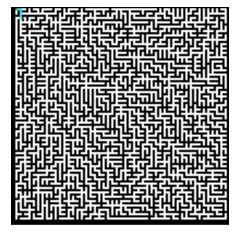

10


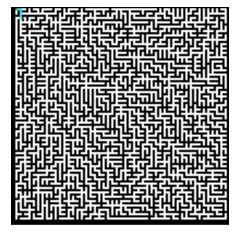

14


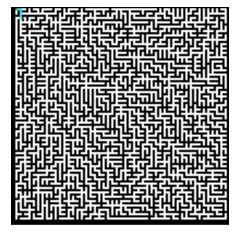

In [8]:
import random
N = 100
S = (1,2)
F = (5,5)
def uniform():
    return random.uniform(0, 1)

def triangular():
    return random.triangular(0, 1)

def betavariate():
     return random.betavariate(3, 4)

map = grid(N, S, F)
pf = pathfinder(S, F, map, uniform,  manhattan_heuristic)
map.draw_map(S, F, pf.get_path())

pf = pathfinder(S, F, map, triangular,  euclidean_heuristic)
map.draw_map(S, F, pf.get_path())

pf = pathfinder(S, F, map, betavariate,  zero_heur)
map.draw_map(S, F, pf.get_path())

In [18]:
import heapq

class pathfinder():

    def __init__(self, S, F, grid, c, h):
        self.S = S
        self.F = F
        self.grid = grid
        self.cost = c
        self.heuristic = h

        self.vis = visualization(S, F)
        self.path=[]
        self.expanded_nodes = 0 #addition
        self.opened = [] 

        self.closed = []       #processed cells
        self.parent = []
        self.costs = [] #addition
        self.heur = []
        self.g = []
        self.f = []
        
        maze = tuple(map.grid)

        def list_adjacents (i, j): #returns the list of the adjacents of a cell
            adjacents = []
            if i>0 and map.grid[i-1][j]!=1:
                adjacents.append((i-1,j))
            if i<N-1 and map.grid[i+1][j]!=1:
                adjacents.append((i+1,j))
            if j>0 and map.grid[i][j-1]!=1:
                adjacents.append((i,j-1))
            if j<N-1 and map.grid[i][j+1]!=1:
                adjacents.append((i,j+1))
            return adjacents
        
        #self.f = np.zeros((N, N))
        self.g= np.zeros((N, N))
        self.heur= np.zeros((N, N))
        start_h = h(S[0],S[1])
        
        
        rowscost=[]
        rowsp=[]
        for i in range(N):
            for j in range(N):
                rowsp.append((-1,-1))
                rowscost.append(c())
                self.f.append(1000000)
            self.parent.append(rowsp)
            self.costs.append(rowscost) #addition
            rowsp=[]
            rowscost=[]
        #print(len(self.f))

        #the a* algorithm starts here
        self.parent[S[0]][S[1]] = (0,0) #set this parent in order to find the start of the path
        self.opened.append(S) #we begin by adding the start to the open list
        self.heur[S[0]][S[1]] = h(S[0], S[1]) #we initialize the heuristic value of the start
        self.f[S[0]*N +S[1]] = h(S[0], S[1])  #we initialize the f value of the start
        self.g[S[0]][S[1]] = 0
        
        while len(self.opened):
            minval = self.f.index(min(self.f)) 
            
   
            cell = (int(minval/N), minval%N)
            
            self.closed.append(cell)
            self.opened.remove(cell)
            

            if cell == F:
                break
               
            adj_cells = list_adjacents(cell[0], cell[1])
            
            for adj_cell in adj_cells:

                x = adj_cell[0]
                y = adj_cell[1]

                if maze[x][y] == 1  or adj_cell  in self.closed: continue
                if self.g[x][y] > self.g[cell[0]][cell[1]] + self.costs[x][y] or adj_cell not in self.opened: 
                    self.g[x][y] = self.g[cell[0]][cell[1]] + self.costs[x][y]
                            
                    self.heur[x][y] = h(x,y)
                        
                    self.parent[x][y] = (cell[0], cell[1])
                        
                    self.f[x*N +y] = self.g[x][y] + self.heur[x][y]
                    if adj_cell not in self.opened:
                        self.opened.append(adj_cell)
                        #print("after the adding of adj opened list is: ", self.opened)
            self.f[minval] = 1000000
        self.path = []
        s = self.parent[F[0]][F[1]]
        while s!=(0,0):
            self.path.append(s)
            s=self.parent[s[0]][s[1]]
        pass
       
    def get_path(self):
        return self.path

In [ ]:
import matplotlib.pyplot as plt
import random

def uniform():
    return random.uniform(0, 1)

def triangular():
    return random.triangular(0, 1)

def betavariate():
     return random.betavariate(3, 4)
info = []
distr = []
heuristic = []
x=[]
for distribution in (uniform, triangular, betavariate):
    for heur in (manhattan_heuristic, euclidean_heuristic, zero_heur):
        for N in range(8,50):
            map = grid(N, (1,2), (N-3, N-4))
            pf = pathfinder((1,2), (N-3, N-4), map, distribution,  heur)
            heuristic.append(len(pf.closed))
        distr.append(heuristic)
        heuristic =[]
    info.append(distr)
    distr = []


for i in range(8,50):
    x.append(i)

#print(info)

plt.plot(x, info[0][0])
plt.plot(x, info[0][1])
plt.plot(x, info[0][2])
plt.plot(x, info[1][0])
plt.plot(x, info[1][1])
plt.plot(x, info[1][2])
plt.plot(x, info[2][0])
plt.plot(x, info[2][1])
plt.plot(x, info[2][2])
plt.show()


